In [467]:
from finn.custom_op.registry import getCustomOp
from finn.transformation.base import Transformation
from finn.util.fpgadataflow import is_fpgadataflow_node
from finn.analysis.fpgadataflow.dataflow_performance import dataflow_performance
from finn.transformation.fpgadataflow.annotate_cycles import AnnotateCycles
from finn.transformation.general import GiveUniqueNodeNames
from finn.transformation.fpgadataflow.set_folding import SetFolding
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from finn.util.fpgadataflow import is_fpgadataflow_node

import matplotlib.pyplot as plt
import random
from copy import deepcopy
import numpy as np

In [468]:
def get_res(model, old_estimation = False):
    luts = 0
    brams = 0
    print('layer', '\t'*5, 'PE', '\t', 'SIMD', '\t', 'MW', '\t', 'inWidth', 'outWidth', '\t', 'LUTs')
    for node in model.graph.node:
        node_inst = getCustomOp(node)
        luts += node_inst.lut_estimation(old_estimation = old_estimation)
        if node.op_type == "StreamingFCLayer_Batch":

            print(node.name, '\t'*2, node_inst.get_nodeattr("PE"), '\t', node_inst.get_nodeattr("SIMD"), '\t', node_inst.get_nodeattr("MW"), '\t', node_inst.get_instream_width(), '\t', node_inst.get_outstream_width(), '\t'*2, node_inst.lut_estimation(old_estimation = old_estimation))
            print('\t', )
            #print('\t', 'BRAM', node_inst.bram_estimation())
            brams += int(node_inst.bram_estimation())
            #print('\t', 'inFIFO', node_inst.get_nodeattr("inFIFODepth"), 'outFIFO', node_inst.get_nodeattr("outFIFODepth"))
            wdt = node_inst.get_weight_datatype()
            W = wdt.bitwidth()
            print('bitwidth', W)
        elif node.op_type == "ConvolutionInputGeneratorPruned":
            print(node.name, '\t'*2, node_inst.get_nodeattr("SIMD"))
        elif node.op_type == "ConvolutionInputGenerator":
            print(node.name, '\t'*3, node_inst.get_nodeattr("SIMD"), '\t'*2, node_inst.get_instream_width(), '\t', node_inst.get_outstream_width(), '\t'*2, node_inst.lut_estimation(old_estimation = old_estimation))
        #elif node.op_type == 'StreamingDataWidthConverter_Batch':
        else:
            #print(node.name, '\t'*2, node_inst.get_nodeattr("inWidth"))
            print(node.name)
#            pass
    print(luts)
    print(brams)

## Exhaustive search over parameter space that constitutes model parallelism

### In order to adhere to _all_ constraints ...
... it is an effective approach to find all possible combinations of parameters. 

**Constraints**

For each network layer (except input Conv layer), need to adhere to following constraints:
Conv layers: 
 - 1. max SIMD is IFMChannels
 - 2. IFMChannels % SIMD == 0
 - 3. Instream and Outstream defined as (SIMD * input width (INT8 for first node, 2-bit for others))
   
   If Outstream > Instream (of following node)
   - Need Outstream % Instream == 0
   
   If Outstream <= Instream (of following node)
   - Need Instream % Outstream == 0
   
FC layers:
 - 1. MW % SIMD == 0
 - 2. MH % PE == 0
 - 3. SIMD > (MW / 1024) (most of the time always fulfiled)
 - 4. Instream (2-bit * SIMD), Outstream (2-bit * PE)
   
   If Outstream > Instream (of following node)
   - Need Outstream % Instream == 0
   
   If Outstream <= Instream (of following node)
   - Need Instream % Outstream == 0
   
MaxPool layers:
Hopefully dont need to handle right now

In [4]:
def plot_cycles(model, title, log = True):
    graph = model.graph
    vals = dict()
    
    for node in graph.node:
        if node.op_type in ("StreamingFCLayer_Batch", "ConvolutionInputGenerator", "ConvolutionInputGeneratorPruned"):
            node_inst = getCustomOp(node)
            vals[node.name] = node_inst.get_exp_cycles()
            
    fig, ax = plt.subplots()
    #fig.patch.set_facecolor('xkcd:mint green')
    ax.set_xticklabels(list(vals.keys()), rotation = 45, ha='right')

    if log:
        ax.set_yscale('log')
        
    fig.suptitle(title, wrap=True)
    plt.ylabel('Cycles')
    
    ax.bar(list(vals.keys()), list(vals.values()))
    for x in ax.get_xticklabels():
        if x.properties().get('text')[:25] == "ConvolutionInputGenerator":
            x.set_weight("bold")
    ax.grid()
    plt.show()

In [5]:
def inst_model(model, from_scratch = True, old_estimation = False):
    new_model = deepcopy(model)
    graph = new_model.graph
    values = dict()
    
    for node in graph.node:
        node_inst = getCustomOp(node)
        if node.name[-1] == "ConvolutionInputGenerator_0":
            pass
        elif node.op_type == "StreamingFCLayer_Batch":
            if from_scratch:
                node_inst.set_nodeattr("SIMD", 1)
                node_inst.set_nodeattr("PE", 1)
        elif node.op_type == "ConvolutionInputGenerator":
            if from_scratch:
                node_inst.set_nodeattr("SIMD", 1)
        if node.op_type != "StreamingMaxPool_Batch":
            node_values = {"LUT": node_inst.lut_estimation(old_estimation = old_estimation), "cycles": node_inst.get_exp_cycles()}
            values[node.name] = node_values
        
    return new_model, values

In [186]:
def get_attrs(model, old_estimation = False):
    a_model = deepcopy(model)
    graph = a_model.graph
    all_vals = dict()

    for node in graph.node:
        #Add check for multiple children?
        children = model.find_consumers(node.output[0])
        if children is None:
            all_vals[node.name] = {"child_layer": None}
        else:
            all_vals[node.name] = {"child_layer": children[0].name}

        all_vals[node.name]["possible_attrs"] = dict()

        node_inst = getCustomOp(node)
        #if node.op_type == "ConvolutionInputGenerator" and not node.name == "ConvolutionInputGenerator_0":
        if node.op_type == "ConvolutionInputGenerator":
            max_simd = node_inst.get_nodeattr("IFMChannels")
            min_simd = node_inst.get_nodeattr("SIMD")

            while min_simd <= max_simd:
                # constraint
                if not max_simd % min_simd:
                    node_inst.set_nodeattr("SIMD", min_simd)
                    old_lut, old_cycles = node_inst.lut_estimation(old_estimation = old_estimation), node_inst.get_exp_cycles()

                    all_vals[node.name]["possible_attrs"][min_simd] = {"inWidth": node_inst.get_instream_width(), "outWidth": node_inst.get_outstream_width(), "LUTs": old_lut, "Cycles": old_cycles, "Viable": None}

                min_simd += 1

        if node.op_type == "StreamingFCLayer_Batch":
            max_simd = node_inst.get_nodeattr("MW")
            max_pe = node_inst.get_nodeattr("MH")

            min_simd = node_inst.get_nodeattr("SIMD")
            old_pe = node_inst.get_nodeattr("PE")
            min_pe = node_inst.get_nodeattr("PE")

            while min_simd <= max_simd:
                min_pe = old_pe
                while min_pe <= max_pe:
                    # constraint
                    if not max_simd % min_simd and not max_pe % min_pe and not node_inst.get_weight_datatype().bitwidth() * min_simd > 36:
                        node_inst.set_nodeattr("SIMD", min_simd)
                        node_inst.set_nodeattr("PE", min_pe)
                        old_lut, old_cycles = node_inst.lut_estimation(old_estimation = old_estimation), node_inst.get_exp_cycles()
                        all_vals[node.name]["possible_attrs"][(min_simd, min_pe)] = {"inWidth": node_inst.get_instream_width(), "outWidth": node_inst.get_outstream_width(), "LUTs": old_lut, "Cycles": old_cycles, "Difference": abs(min_simd - min_pe), "Viable": None}
                        all_vals[node.name]["original_mw"] = max_simd

                    min_pe += 1
                min_simd += 1
    return all_vals

In [7]:
def make_mask(amount, simd_list):
    # flattened dimensions of each layer
    dims = [27,576,576,1152,1152,2304]
    masks = []
    for i, (dim, simd) in enumerate(zip(dims, simd_list)):
        #print("layer", i)
        # new shape of the array, which makes it easier to create the blocks afterward 
        # by repeating the elements simd times
        new_shape = dim // simd
        # number of pruned parameters have to be divisible by simd
        params_to_keep = new_shape - int(new_shape * amount)
        params_to_keep += simd
        params_to_keep -= params_to_keep % simd

        #print("params_to_keep", params_to_keep * simd)
        # create mask full of 1
        layer_mask = [1] * new_shape
        #print('\t', (new_shape-new_params)*simd )
        # set params_pruned elements to 0
        layer_mask[:params_to_keep] = [0] * params_to_keep
        # shuffle the elements
        random.shuffle(layer_mask)
        masks.append(np.repeat(layer_mask, simd).tolist())
    return masks

In [324]:
# used to set new dimension(s) of FC layer if updating SIMDs during pruning

def get_new_mw(old_mw, pruning_ratio, idx, simd):
    dims = [27,576,576,1152,1152,2304]
    dim = dims[idx]
    
    new_shape = dim // simd
    params_to_keep = new_shape - int(np.round(new_shape * pruning_ratio))
    if params_to_keep > simd:
        params_to_keep += simd
        params_to_keep -= params_to_keep % simd
    
    layer_mask = [1] * new_shape
    
    layer_mask[:params_to_keep] = [0] * params_to_keep
    
    random.shuffle(layer_mask)
    
    mask = sum(np.repeat(layer_mask, simd).tolist())
    
    return old_mw - mask

In [348]:
def increase_parallelism(model, attrs, target_cycles, pruning_ratio = None):
    new_model = deepcopy(model)
    graph = new_model.graph

    for node in graph.node:
        if node.op_type == "StreamingFCLayer_Batch":
            node_inst = getCustomOp(node)
            ss = node_inst.get_nodeattr("SIMD")
            pp = node_inst.get_nodeattr("PE")
            print(f"{node.name} had original SIMD {ss} and PE {pp}")
            node_attrs = attrs.get(node.name).get("possible_attrs")
            # if pruning is taken into account during optimization, order
            # possible attrs not by biggest SIMD but rather balanced values
            if pruning_ratio:
                sorted_attrs = sorted(node_attrs.items(), key = lambda k_v: (k_v[1].get('Cycles'), -k_v[1].get('Difference')), reverse = True)
            if not pruning_ratio:
                sorted_attrs = sorted(node_attrs.items(), key = lambda k_v: (k_v[1].get('Cycles'), k_v[0][0]), reverse = True)
            child_layer = attrs.get(node.name).get("child_layer")
            if child_layer:
                child_layer_attrs = attrs.get(child_layer)
            
            for setting in sorted_attrs:
                if setting[1].get('Cycles') < target_cycles:
                    new_simd = setting[0][0]
                    new_pe = setting[0][1]
                    print(f"{node.name} got new SIMD {new_simd} and PE {new_pe}")
                    
                    node_inst.set_nodeattr("SIMD", new_simd)
                    node_inst.set_nodeattr("PE", new_pe)
                    
                    # if pruning, need to update new MW if changing SIMD
                    idx = int(node.name[-1])
                    if pruning_ratio and idx < 6:
                        #old_mw = node_inst.get_nodeattr("MW")
                        original_mw = attrs[node.name]["original_mw"]
                        idx = int(node.name[-1])
                        new_mw = get_new_mw(original_mw, pruning_ratio, idx, new_simd)
                        print(f"updating MW from {original_mw} to {new_mw} and possible attrs for node {node.name}")
                        node_inst.set_nodeattr("MW", new_mw)
                        attrs[node.name]["possible_attrs"] = update_node_attrs(node_inst, attrs[node.name]["possible_attrs"])
                        
                    # update viability of next layer
                    if child_layer:
                        for k,v in child_layer_attrs.get("possible_attrs").items():
                            
                            if setting[1].get("outWidth") > v.get("inWidth"):
                                if not setting[1].get("outWidth") % v.get("inWidth"):
                                    v["Viable"] = True
                                else:
                                    v["Viable"] = False
                            #elif setting[1].get("outWidth") <= v.get("inWidth"):
                            else:
                                if not v.get("inWidth") % setting[1].get("outWidth"):
                                    v["Viable"] = True
                                else:
                                    v["Viable"] = False
                    break
                    
    # Set viability of child layers that are FC layers, is this necessary?
    for node in graph.node:
        if node.op_type == "ConvolutionInputGenerator":
            pass

    return new_model, attrs

In [12]:
def update_node_attrs(node_inst, node_attrs):
    new_possible_attrs = dict()
    old_simd, old_pe = (node_inst.get_nodeattr("SIMD"), node_inst.get_nodeattr("PE"))
    for setting, v in node_attrs.items():
        new_simd, new_pe = setting
        node_inst.set_nodeattr("SIMD", new_simd)
        node_inst.set_nodeattr("PE", new_pe)
        
        node_attrs = dict()
        for attr, val in v.items():
            if attr in ("inWidth", "outWidth", "Difference", "Viable"):
                node_attrs[attr] = val
            elif attr == "LUTs":
                node_attrs[attr] = node_inst.lut_estimation()
            elif attr == "Cycles":
                node_attrs[attr] = node_inst.get_exp_cycles()
        new_possible_attrs[setting] = node_attrs
    node_inst.set_nodeattr("SIMD", old_simd)
    node_inst.set_nodeattr("PE", old_pe)
    return new_possible_attrs

In [202]:
def get_next_val(node, current_attrs, total_luts, max_luts, old_estimation = False, child_node = None, pruning_ratio = None):
    node_inst = getCustomOp(node)
    child_layer = current_attrs.get(node.name).get("child_layer")
    done = False
    print(node.name, "with child", child_layer)
    if child_layer:
        child_layer_attrs = current_attrs.get(child_layer)
            
            
    if node.op_type == "StreamingFCLayer_Batch":
        node_key = (node_inst.get_nodeattr("SIMD"), node_inst.get_nodeattr("PE"))
        node_luts = node_inst.lut_estimation(old_estimation = old_estimation)
        print(f"Current SIMD and PE {node_key}")
        node_attrs = current_attrs.get(node.name).get("possible_attrs")
        # if pruning is taken into account during optimization, order
        # possible attrs not by biggest SIMD but rather balanced values
        if pruning_ratio:
            sorted_attrs = sorted(node_attrs.items(), key = lambda k_v: (k_v[1].get('Cycles'), -k_v[1].get('Difference')), reverse = True)
        if not pruning_ratio:
            sorted_attrs = sorted(node_attrs.items(), key = lambda k_v: (k_v[1].get('Cycles'), k_v[0][0]), reverse = True)
        if not len(sorted_attrs):
            return node_key, current_attrs, done
    elif node.op_type == "ConvolutionInputGenerator":
        node_key = node_inst.get_nodeattr("SIMD")
        node_luts = node_inst.lut_estimation(old_estimation = old_estimation)
        print(f"Current SIMD {node_key}")
        node_attrs = current_attrs.get(node.name).get("possible_attrs")
        sorted_attrs = sorted(node_attrs.items(), key = lambda k_v: k_v[1].get('Cycles'), reverse = True)
        if not len(sorted_attrs):
            return node_key, current_attrs, done
        
        # for case where child layer is fclayer and has a certain SIMD, 
        # we dont want inpgen to update its' SIMD to anything above that
        if pruning_ratio:
            child_node_inst = getCustomOp(child_node)
            child_node_simd = child_node_inst.get_nodeattr("SIMD")
            for v in sorted_attrs:
                attr, settings = v[0], v[1]
                if v[0] > child_node_simd:
                    v[1]["Viable"] = False
    
    for idx, v in enumerate(sorted_attrs):
        if v[0] == node_key:
            next_layer = idx+1
            print(node_inst.get_exp_cycles(), sorted_attrs[next_layer][1].get("Cycles"))
            while (node_inst.get_exp_cycles() <= sorted_attrs[next_layer][1].get("Cycles")):
                next_layer += 1
            
                
            # try to find a viable config with same cycles
            if sorted_attrs[next_layer][1].get("Viable") == False:
                # return if we are at end of possible configs

                if next_layer+1 >= len(sorted_attrs):
                    done = True
                    return sorted_attrs[idx][0], current_attrs, done
                
                while sorted_attrs[next_layer][1].get("Cycles") == sorted_attrs[next_layer+1][1].get("Cycles"):
                    if not sorted_attrs[next_layer+1][1].get("Viable"):
                        next_layer += 1
                    else:
                        next_layer += 1
                        break
                
            if (sorted_attrs[next_layer][1].get("Viable") == True or sorted_attrs[next_layer][1].get("Viable") is None) and (sorted_attrs[next_layer][1].get("LUTs") - node_luts + total_luts) < max_luts:
                    
                # update viability of next layer
                if child_layer:
                    for k,v in child_layer_attrs.get("possible_attrs").items():
                        if sorted_attrs[next_layer][1].get("outWidth") > v.get("inWidth"):
                            if not sorted_attrs[next_layer][1].get("outWidth") % v.get("inWidth"):
                                v["Viable"] = True
                            else:
                                v["Viable"] = False
                        elif sorted_attrs[next_layer][1].get("outWidth") <= v.get("inWidth"):
                            if not v.get("inWidth") % sorted_attrs[idx+1][1].get("outWidth"):
                                v["Viable"] = True
                            else:
                                v["Viable"] = False
                                
                        #if layer is inpgen and child layer is fclayer, make sure SIMDs can only be higher than of inpgen
                        if pruning_ratio:
                            if node.op_type == "ConvolutionInputGenerator" and child_layer[:-2] == "StreamingFCLayer_Batch":
                                if k[0] < sorted_attrs[next_layer][0]:
                                    v["Viable"] = False
                                elif v["Viable"] == True or v["Viable"] == None:
                                    v["Viable"] = True
                                
                return sorted_attrs[next_layer][0], current_attrs, done
            else:
                # skip entire cycle-level.
                # if no viable options from previous cycle-level, try to skip, 
                # check for viable configs and see if still within LUT budget
                checked_layer = sorted_attrs[next_layer]
                
                # if we're at the slowest layer and no configs are possible
                # we need to stop optimization
                optimizable = False
                
                for attr in sorted_attrs[next_layer:]:
                    attr_luts = attr[1].get("LUTs")
                    if (attr_luts - node_luts + total_luts) < max_luts and attr[1].get("Viable"):
                        if child_layer:
                            for k,v in child_layer_attrs.get("possible_attrs").items():
                                if attr[1].get("outWidth") > v.get("inWidth"):
                                    if not attr[1].get("outWidth") % v.get("inWidth"):
                                        v["Viable"] = True
                                    else:
                                        v["Viable"] = False
                                else:
                                    if not v.get("inWidth") % attr[1].get("outWidth"):
                                        v["Viable"] = True
                                    else:
                                        v["Viable"] = False
                                #if layer is inpgen and child layer is fclayer, make sure SIMDs can only be higher than of inpgen
                                if pruning_ratio:
                                    if node.op_type == "ConvolutionInputGenerator" and child_layer[:-2] == "StreamingFCLayer_Batch":
                                        if k[0] < attr[0]:
                                            v["Viable"] = False
                                        elif v["Viable"] == True or v["Viable"] == None:
                                            v["Viable"] = True
                                        
                        return attr[0], current_attrs, done
                    elif (attr_luts - node_luts + total_luts) > max_luts:
                        done = True
                        print('next attrs were not viable due to LUT budget')
                    elif attr[1].get("Viable"):
                        optimizable = True

                if not optimizable:
                    done = True
                    
                print('next attrs were not viable')
                return sorted_attrs[idx][0], current_attrs, done

In [374]:
def step_2(model, among_slowest, attrs, inplace = False, first_run = True, max_luts = 53200, old_estimation = False, pruning_ratio = None):
    done = False
    print('step 2')
    verbose = True
    
    total_luts = 0
    all_cycles_dict = dict()
    if not inplace:
        new_model = deepcopy(model)
    else:
        new_model = model
    
    for node in new_model.graph.node:
        node_inst = getCustomOp(node)
        all_cycles_dict[node.name] = node_inst.get_exp_cycles()
        total_luts += node_inst.lut_estimation(old_estimation = old_estimation)
    print(f"total luts {total_luts}")
    
    if first_run:
        all_cycles = sorted(all_cycles_dict.items(), key=lambda item: item[1], reverse=True)
        among_slowest[all_cycles[0][0]] = {'cycles': all_cycles[0][1]}
        
        for k,v in all_cycles_dict.items():
            all_cycles_dict[k] = 0
        
        return new_model, among_slowest, all_cycles_dict
    else:
        among_slowest = among_slowest
        
    for node in new_model.graph.node:
        if node.name in among_slowest.keys() and not among_slowest[node.name].get("skip"):
            node_inst = getCustomOp(node)
            op_type = node.op_type
            #if node.name in node.name in ("ConvolutionInputGeneratorPruned_0", "ConvolutionInputGenerator_0"):
            #    done = True

            if op_type in ("ConvolutionInputGenerator","ConvolutionInputGeneratorPruned"):
                print(node.name)
                child_node = new_model.find_consumers(node.output[0])[0]
                val, attrs, done = get_next_val(node, attrs, total_luts, max_luts, old_estimation, child_node, pruning_ratio=pruning_ratio)
                old_lut = node_inst.lut_estimation(old_estimation = old_estimation)
                prev_simd_val = node_inst.get_nodeattr("SIMD")
                
                if verbose:
                    print('prev simd', prev_simd_val)
                    print('new simd', val)
                node_inst.set_nodeattr("SIMD", val)
                new_lut = node_inst.lut_estimation(old_estimation = old_estimation)
                if verbose:
                    print('old lut', old_lut)
                    print('new lut', new_lut)
                    print('total luts went up by', new_lut - old_lut)

                if (total_luts - old_lut + new_lut) > max_luts:
                    node_inst.set_nodeattr("SIMD", prev_simd_val)
                    if verbose:
                        print(f'went above threshold for new: {total_luts - old_lut + new_lut}')
                        done = True
                    #break
                else:
                    prev_cycles[node.name] = among_slowest[node.name]['cycles']
                    among_slowest[node.name]['cycles'] = node_inst.get_exp_cycles()

                    print(f'cycles after node {node.name}: {node_inst.get_exp_cycles()}')
                    total_luts -= old_lut
                    total_luts += new_lut

            if op_type == "StreamingFCLayer_Batch":
                max_simd = node_inst.get_nodeattr("MW")
                max_pe = node_inst.get_nodeattr("MH")
                
                old_lut = node_inst.lut_estimation()
                prev_simd_val = node_inst.get_nodeattr("SIMD")
                min_simd = prev_simd_val
                prev_pe_val = node_inst.get_nodeattr("PE")
                min_pe = prev_pe_val
                print(f"min_simd {min_simd}, max_simd {max_simd}")

                if not total_luts > max_luts:
                    print(f'cycles before SIMD for node {node.name}: {node_inst.get_exp_cycles()}')

                    vals, attrs, done = get_next_val(node, attrs, total_luts, max_luts, old_estimation, pruning_ratio=pruning_ratio)
                    new_simd_val, new_pe_val = vals
                        
                    if verbose:
                        print('prev simd and pe', prev_simd_val, prev_pe_val)
                        print('new simd and pe', new_simd_val, new_pe_val)
                    node_inst.set_nodeattr("SIMD", new_simd_val)
                    node_inst.set_nodeattr("PE", new_pe_val)
                    
                    new_lut = node_inst.lut_estimation(old_estimation = old_estimation)
                    
                    if verbose:
                        print('old lut', old_lut)
                        print('new lut', new_lut)
                        print('total luts went up by', new_lut - old_lut)

                    # revert if we've gone above width threshold
                    if (node_inst.get_weight_datatype().bitwidth()
                        * node_inst.get_nodeattr("SIMD")
                        > 36
                       ) or (total_luts - old_lut + new_lut) > max_luts:
                        node_inst.set_nodeattr("SIMD", prev_simd_val)
                        node_inst.set_nodeattr("PE", prev_pe_val)
                        if verbose:
                            print(f'went above threshold for new: {total_luts - old_lut + new_lut}')
                            if (total_luts - old_lut + new_lut) > max_luts:
                                done = True

                    else:
                        #calculate new node shape based on mask
                        idx = int(node.name[-1])
                        if pruning_ratio and idx < 6:
                            print(f"updating MW and possible attrs for node {node.name}")
                            original_mw = attrs[node.name]["original_mw"]
                            #old_mw = node_inst.get_nodeattr("MW")
                            print(original_mw, pruning_ratio, idx, new_simd_val)
                            new_mw = get_new_mw(original_mw, pruning_ratio, idx, new_simd_val)
                            print(f"old MW was {original_mw}, new MW is {new_mw}")
                            node_inst.set_nodeattr("MW", new_mw)
                            attrs[node.name]["possible_attrs"] = update_node_attrs(node_inst, attrs[node.name]["possible_attrs"])
                            
                        prev_cycles[node.name] = among_slowest[node.name]['cycles']
                        among_slowest[node.name]['cycles'] = node_inst.get_exp_cycles()
                        
                            
                        print(f'cycles after SIMD for node {node.name}: {node_inst.get_exp_cycles()}')
                        total_luts -= old_lut
                        total_luts += new_lut

                    

        print('done with node', node.name)
                
    return new_model, attrs, among_slowest, done

### For 4- and 8-bit models, need to cast a node INT to UINT

In [305]:
model = ModelWrapper("pruned_models/model_best_8bit_neil.onnx")

estimates_output_dir = f"modelling_estimates/estimate_fold_1_base_8bit_nonpruned"
cfg = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    synth_clk_period_ns = 10.0,
    board               = "Pynq-Z1",
    shell_flow_type     = build_cfg.ShellFlowType.VIVADO_ZYNQ,
    steps               = [
        "step_tidy_up",
        "step_streamline"
    ],
    generate_outputs    = []
)
build.build_dataflow_cfg("pruned_models/model_best_8bit_neil.onnx", cfg)

#model = ModelWrapper("modelling_estimates/estimate_fold_1_base_4bit_nonpruned/intermediate_models/2_step_streamline.onnx")

Building dataflow accelerator from pruned_models/model_best_8bit_neil.onnx
Intermediate outputs will be generated in /tmp/finn_dev_neni
Final outputs will be generated in modelling_estimates/estimate_fold_1_base_8bit_nonpruned
Build log is at modelling_estimates/estimate_fold_1_base_8bit_nonpruned/build_dataflow.log
Running step: step_tidy_up [1/2]
Running step: step_streamline [2/2]
Completed successfully


0

In [59]:
from finn.core.datatype import DataType

In [310]:
def set_uint(model):
    #new_model = deepcopy(model)
    new_model =model
    
    graph = new_model.graph

    for n in graph.node:
        mm_output = n.output[0]
        consumer = model.find_consumer(mm_output)
        if consumer:
            mt_output = consumer.output[0]
            odt = model.get_tensor_datatype(mt_output)
            if mm_output == "MultiThreshold_6_out0":
                n_inst = getCustomOp(n)
                n_inst.set_nodeattr("out_dtype", "UINT8")
                new_model.set_tensor_datatype("MultiThreshold_6_out0", DataType.UINT8)
                
                print(n.output[0])
                print(new_model.get_tensor_datatype(n.output[0]))
    return new_model

In [311]:
model = ModelWrapper("modelling_estimates/estimate_fold_1_base_8bit_nonpruned/intermediate_models/2_step_streamline.onnx")

In [312]:
new_model = set_uint(model)

MultiThreshold_6_out0
DataType.UINT8


In [314]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
from finn.util.test import get_test_model_trained
import brevitas.onnx as bo

#model_file_path = "pruned_models/model_2bit/2bit_nonpruned.onnx"

#cnv = get_test_model_trained("CNV", 2, 2)
#bo.export_finn_onnx(cnv, (1, 3, 32, 32), model_file_path)

#model_file_path = "pruned_models/model_best_4bit_streamlined_uint.onnx"
model_file_path = "pruned_models/model_best_8bit_streamlined_uint.onnx"

steps = [
    #"step_tidy_up",
    #"step_streamline",
    "step_convert_to_hls",
    "step_create_dataflow_partition",
    "step_target_fps_parallelization",
    "step_apply_folding_config",
]

estimates_output_dir = f"modelling_estimates/estimate_fold_1_base_8bit_nonpruned"
cfg = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    folding_config_file = "exhaustive_folding/model_1bit_fold_1.json",
    synth_clk_period_ns = 10.0,
    board               = "Pynq-Z1",
    shell_flow_type     = build_cfg.ShellFlowType.VIVADO_ZYNQ,
    steps               = steps,
    generate_outputs = [
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
        build_cfg.DataflowOutputType.STITCHED_IP,
        #build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)
build.build_dataflow_cfg(model_file_path, cfg)

Building dataflow accelerator from pruned_models/model_best_8bit_streamlined_uint.onnx
Intermediate outputs will be generated in /tmp/finn_dev_neni
Final outputs will be generated in modelling_estimates/estimate_fold_1_base_8bit_nonpruned
Build log is at modelling_estimates/estimate_fold_1_base_8bit_nonpruned/build_dataflow.log
Running step: step_convert_to_hls [1/4]
Running step: step_create_dataflow_partition [2/4]
Running step: step_target_fps_parallelization [3/4]
Running step: step_apply_folding_config [4/4]
Completed successfully


0

In [ ]:
# 8 bit - way too high fold 1 resource use
# LUTs are 281844 as per below
model = ModelWrapper('modelling_estimates/estimate_fold_1_base_8bit_nonpruned/intermediate_models/4_step_apply_folding_config.onnx')

In [559]:
get_res(model)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 3 	 27 	 24 	 8 		 12456
	
bitwidth 8
ConvolutionInputGenerator_1 			 1 		 8 	 8 		 1260
StreamingFCLayer_Batch_1 		 1 	 1 	 576 	 8 	 8 		 15020
	
bitwidth 8
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 8 	 8 		 748
StreamingFCLayer_Batch_2 		 1 	 1 	 576 	 8 	 8 		 22313
	
bitwidth 8
ConvolutionInputGenerator_3 			 1 		 8 	 8 		 1068
StreamingFCLayer_Batch_3 		 1 	 2 	 1152 	 16 	 8 		 23279
	
bitwidth 8
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 8 	 8 		 620
StreamingFCLayer_Batch_4 		 1 	 2 	 1152 	 16 	 8 		 38426
	
bitwidth 8
ConvolutionInputGenerator_5 			 1 		 8 	 8 		 684
StreamingFCLayer_Batch_5 		 1 	 4 	 2304 	 32 	 8 		 40076
	
bitwidth 8
StreamingFCLayer_Batch_6 		 1 	 1 	 256 	 8 	 8 		 61020
	
bitwidth 8
StreamingFCLayer_Batch_7 		 1 	 1 	 512 	 8 	 8 		 63545
	
bitwidth 8
StreamingFCLayer_Batch_8 		 5

In [546]:
def step_3(model, among_slowest, prev_slowest_cycles = 0, prev_slowest_name = None):

    print('step 3')
    slowest_layer = sorted(among_slowest.items(), key=lambda item: item[1].get('cycles'), reverse=True)[0]
    #among_slowest = {slowest_layer[0]: slowest_layer[1]}
    added = False
    for node in model.graph.node:
        node_inst = getCustomOp(node)
        #print(node.name, node_inst.get_exp_cycles())
        if node_inst.get_exp_cycles() > slowest_layer[1].get('cycles'):
            print(f"going to add: {node.name} since speed {node_inst.get_exp_cycles()} is slower than {slowest_layer[1].get('cycles')}")
            among_slowest[node.name] = {'cycles': node_inst.get_exp_cycles()}
            added = True
        #elif node_inst.get_exp_cycles() < slowest_layer[1].get('cycles'):
        #    among_slowest.pop(node.name, None)

    new_among_slowest = dict()
    equal_cyc = 0
    for node, values in among_slowest.items():
        if values.get('cycles') < prev_slowest_cycles:
            print(f"removing {node} from slowest since speed {values.get('cycles')} is faster than {slowest_layer[1].get('cycles')}")
            values["skip"] = True
            new_among_slowest[node] = values
            
            if values.get('cycles') == prev_slowest_cycles:
                equal_cyc += 1
        else:
            values["skip"] = False
            new_among_slowest[node] = values
    
    if prev_slowest_name:
        for node, vals in new_among_slowest.items():
            if vals["cycles"] > prev_slowest_cycles:
                print(f"removed the previous slowest {prev_slowest_name}")
                new_among_slowest[prev_slowest_name]["skip"] = True
                break
    print("new slowest", new_among_slowest)
    
    
    return model, new_among_slowest, added

In [548]:
def get_luts(model):
    luts = 0
    for node in model.graph.node:
        node_inst = getCustomOp(node)
        luts += node_inst.lut_estimation()
    return luts

In [549]:
def step_4(model, among_slowest, attrs, max_luts = 53200, pruning_ratio = None):
    added = False
    done = False
    model_luts = 0
    while model_luts < max_luts and not done:
        print(f'loop, current_luts: {model_luts} max_luts: {max_luts}, {done}')
        model_luts = get_luts(model)
        if not added:
            # updates speed of slowest layers by factor of 2
            model, attrs, among_slowest, done = step_2(model, among_slowest, attrs, first_run = False, max_luts = max_luts, pruning_ratio = pruning_ratio)
            print('returned from step 2', among_slowest, done)
            
            sorted_among_slowest = sorted(among_slowest.items(), key=lambda item: item[1].get('cycles'), reverse=True)
            prev_slowest_cycles, prev_slowest_name = sorted_among_slowest[0][1].get('cycles'), sorted_among_slowest[0][0]
        
        model, among_slowest, added = step_3(model, among_slowest, prev_slowest_cycles, prev_slowest_name)
    
    return model, among_slowest

### Main body of algorithm

In [558]:
#pruning_ratio = 0.75
pruning_ratio = None

# Pynq Z-1
default_luts = 53200
# Ultra96
#default_luts = 71000

max_luts_ratio = 0.85

max_luts = default_luts * max_luts_ratio

# 1 bit
#model = ModelWrapper('modelling_estimates/estimate_fold_1_base_1bit_nonpruned/intermediate_models/6_step_apply_folding_config.onnx')

# 2 bit
#model = ModelWrapper('modelling_estimates/estimate_pruned_fold_1_base_luts_2bit_nonpruned/intermediate_models/6_step_apply_folding_config.onnx')

# 4 bit
#model = ModelWrapper('modelling_estimates/estimate_fold_1_base_4bit_nonpruned/intermediate_models/4_step_apply_folding_config.onnx')

# 8 bit - way too high fold 1 resource use
model = ModelWrapper('modelling_estimates/estimate_fold_1_base_8bit_nonpruned/intermediate_models/4_step_apply_folding_config.onnx')

all_attrs = get_attrs(model)

model_inst, values = inst_model(model, from_scratch=True)

int_values = {k: v for k, v in values.items() if k[:25] == "ConvolutionInputGenerator"}

target_cycles = sorted(int_values.items(), key=lambda item: item[1].get('cycles'), reverse=True)[0][1].get('cycles')

# increase parallelism of FC layers until below slowest conv layer
model_par, new_all_attrs = increase_parallelism(model_inst, all_attrs, target_cycles, pruning_ratio=pruning_ratio)

# saving cycles of this step for viz later
viz_vals = dict()
for node in model_par.graph.node:
    if node.op_type in ("StreamingFCLayer_Batch", "ConvolutionInputGenerator", "ConvolutionInputGeneratorPruned"):
        node_inst = getCustomOp(node)
        viz_vals[node.name] = node_inst.get_exp_cycles()

StreamingFCLayer_Batch_0 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_0 got new SIMD 3 and PE 2
StreamingFCLayer_Batch_1 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_1 got new SIMD 4 and PE 16
StreamingFCLayer_Batch_2 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_2 got new SIMD 3 and PE 8
StreamingFCLayer_Batch_3 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_3 got new SIMD 3 and PE 16
StreamingFCLayer_Batch_4 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_4 got new SIMD 3 and PE 2
StreamingFCLayer_Batch_5 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_5 got new SIMD 4 and PE 1
StreamingFCLayer_Batch_6 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_6 got new SIMD 1 and PE 1
StreamingFCLayer_Batch_7 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_7 got new SIMD 1 and PE 1
StreamingFCLayer_Batch_8 had original SIMD 1 and PE 1
StreamingFCLayer_Batch_8 got new SIMD 1 and PE 5


In [545]:
new_model, among_slowest, prev_cycles = step_2(model_par, dict(), new_all_attrs, old_estimation=False)

step 2
total luts 9871


In [547]:
new_model, among_slowest, added = step_3(new_model, among_slowest)

step 3
new slowest {'ConvolutionInputGenerator_1': {'cycles': 457344, 'skip': False}}


In [550]:
new_model, among_slowest = step_4(new_model, among_slowest, new_all_attrs, max_luts=max_luts, pruning_ratio=pruning_ratio)

loop, current_luts: 0 max_luts: 45220.0, False
step 2
total luts 9871
done with node ConvolutionInputGenerator_0
done with node StreamingFCLayer_Batch_0
ConvolutionInputGenerator_1
ConvolutionInputGenerator_1 with child StreamingFCLayer_Batch_1
Current SIMD 1
457344 228672
prev simd 1
new simd 2
old lut 540
new lut 540
total luts went up by 0
cycles after node ConvolutionInputGenerator_1: 228672
done with node ConvolutionInputGenerator_1
done with node StreamingFCLayer_Batch_1
done with node StreamingMaxPool_Batch_0
done with node ConvolutionInputGenerator_2
done with node StreamingFCLayer_Batch_2
done with node ConvolutionInputGenerator_3
done with node StreamingFCLayer_Batch_3
done with node StreamingMaxPool_Batch_1
done with node ConvolutionInputGenerator_4
done with node StreamingFCLayer_Batch_4
done with node ConvolutionInputGenerator_5
done with node StreamingFCLayer_Batch_5
done with node StreamingFCLayer_Batch_6
done with node StreamingFCLayer_Batch_7
done with node StreamingFC

total luts 12503
done with node ConvolutionInputGenerator_0
done with node StreamingFCLayer_Batch_0
ConvolutionInputGenerator_1
ConvolutionInputGenerator_1 with child StreamingFCLayer_Batch_1
Current SIMD 2
228672 114336
prev simd 2
new simd 4
old lut 540
new lut 556
total luts went up by 16
cycles after node ConvolutionInputGenerator_1: 114336
done with node ConvolutionInputGenerator_1
done with node StreamingFCLayer_Batch_1
done with node StreamingMaxPool_Batch_0
done with node ConvolutionInputGenerator_2
done with node StreamingFCLayer_Batch_2
done with node ConvolutionInputGenerator_3
done with node StreamingFCLayer_Batch_3
done with node StreamingMaxPool_Batch_1
done with node ConvolutionInputGenerator_4
done with node StreamingFCLayer_Batch_4
done with node ConvolutionInputGenerator_5
done with node StreamingFCLayer_Batch_5
done with node StreamingFCLayer_Batch_6
done with node StreamingFCLayer_Batch_7
done with node StreamingFCLayer_Batch_8
returned from step 2 {'ConvolutionInpu

done with node ConvolutionInputGenerator_5
min_simd 4, max_simd 2304
cycles before SIMD for node StreamingFCLayer_Batch_5: 147456
StreamingFCLayer_Batch_5 with child StreamingFCLayer_Batch_6
Current SIMD and PE (4, 1)
147456 98304
prev simd and pe 4 1
new simd and pe 6 1
old lut 630
new lut 656
total luts went up by 26
cycles after SIMD for node StreamingFCLayer_Batch_5: 98304
done with node StreamingFCLayer_Batch_5
done with node StreamingFCLayer_Batch_6
done with node StreamingFCLayer_Batch_7
done with node StreamingFCLayer_Batch_8
returned from step 2 {'ConvolutionInputGenerator_1': {'cycles': 114336, 'skip': True}, 'StreamingFCLayer_Batch_0': {'cycles': 129600, 'skip': True}, 'StreamingFCLayer_Batch_1': {'cycles': 112896, 'skip': True}, 'StreamingFCLayer_Batch_2': {'cycles': 110592, 'skip': True}, 'StreamingFCLayer_Batch_3': {'cycles': 115200, 'skip': True}, 'StreamingFCLayer_Batch_4': {'cycles': 110592, 'skip': True}, 'StreamingFCLayer_Batch_7': {'cycles': 131072, 'skip': True}, '

new simd and pe 12 16
old lut 3089
new lut 4612
total luts went up by 1523
cycles after SIMD for node StreamingFCLayer_Batch_3: 76800
done with node StreamingFCLayer_Batch_3
done with node StreamingMaxPool_Batch_1
done with node ConvolutionInputGenerator_4
done with node StreamingFCLayer_Batch_4
done with node ConvolutionInputGenerator_5
done with node StreamingFCLayer_Batch_5
done with node StreamingFCLayer_Batch_6
done with node StreamingFCLayer_Batch_7
done with node StreamingFCLayer_Batch_8
returned from step 2 {'ConvolutionInputGenerator_1': {'cycles': 57168, 'skip': True}, 'StreamingFCLayer_Batch_0': {'cycles': 86400, 'skip': True}, 'StreamingFCLayer_Batch_1': {'cycles': 56448, 'skip': True}, 'StreamingFCLayer_Batch_2': {'cycles': 82944, 'skip': True}, 'StreamingFCLayer_Batch_3': {'cycles': 76800, 'skip': False}, 'StreamingFCLayer_Batch_4': {'cycles': 82944, 'skip': True}, 'StreamingFCLayer_Batch_7': {'cycles': 65536, 'skip': True}, 'StreamingFCLayer_Batch_5': {'cycles': 98304, '

step 2
total luts 29656
done with node ConvolutionInputGenerator_0
done with node StreamingFCLayer_Batch_0
done with node ConvolutionInputGenerator_1
done with node StreamingFCLayer_Batch_1
done with node StreamingMaxPool_Batch_0
done with node ConvolutionInputGenerator_2
done with node StreamingFCLayer_Batch_2
ConvolutionInputGenerator_3
ConvolutionInputGenerator_3 with child StreamingFCLayer_Batch_3
Current SIMD 2
59904 29952
prev simd 2
new simd 4
old lut 492
new lut 492
total luts went up by 0
cycles after node ConvolutionInputGenerator_3: 29952
done with node ConvolutionInputGenerator_3
done with node StreamingFCLayer_Batch_3
done with node StreamingMaxPool_Batch_1
done with node ConvolutionInputGenerator_4
done with node StreamingFCLayer_Batch_4
done with node ConvolutionInputGenerator_5
done with node StreamingFCLayer_Batch_5
done with node StreamingFCLayer_Batch_6
done with node StreamingFCLayer_Batch_7
done with node StreamingFCLayer_Batch_8
returned from step 2 {'ConvolutionI

### Results

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


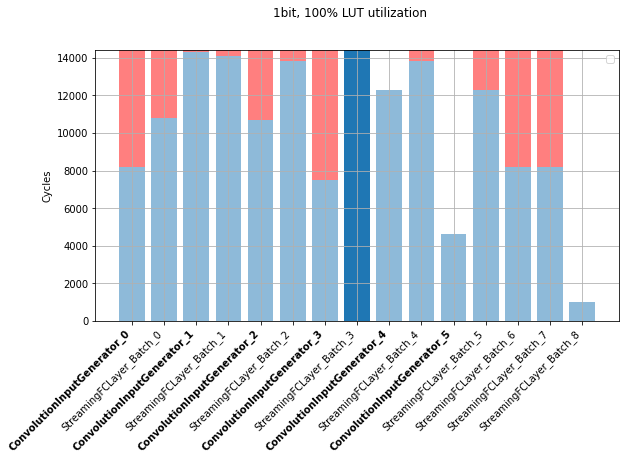

In [689]:
plot_cycles_remainder(new_model, viz_vals, "1bit, 100% LUT utilization", log=False, start=False)

In [690]:
get_res(new_model) #1 bit, no pruning, 100% utilization

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 3 		 24 	 24 		 396
StreamingFCLayer_Batch_0 		 16 	 9 	 27 	 72 	 16 		 8008
	
ConvolutionInputGenerator_1 			 32 		 32 	 32 		 428
StreamingFCLayer_Batch_1 		 64 	 32 	 576 	 32 	 64 		 16210
	
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 8 		 8 	 8 		 364
StreamingFCLayer_Batch_2 		 32 	 24 	 576 	 24 	 32 		 6565
	
ConvolutionInputGenerator_3 			 16 		 16 	 16 		 428
StreamingFCLayer_Batch_3 		 128 	 8 	 1152 	 8 	 128 		 12268
	
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 1 	 1 		 340
StreamingFCLayer_Batch_4 		 8 	 24 	 1152 	 24 	 8 		 1892
	
ConvolutionInputGenerator_5 			 1 		 1 	 1 		 348
StreamingFCLayer_Batch_5 		 2 	 24 	 2304 	 24 	 2 		 735
	
StreamingFCLayer_Batch_6 		 1 	 16 	 256 	 16 	 1 		 513
	
StreamingFCLayer_Batch_7 		 1 	 32 	 512 	 32 	 1 		 630
	
StreamingFCLayer_Batch_8 		 5 	 1 	 512 	 1 	 80 		 382
	
49507
195


In [507]:
get_res(new_model) #4 bit, 15% pruning, 85% utilization

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 9 	 27 	 72 	 4 		 1460
	
bitwidth 4
ConvolutionInputGenerator_1 			 4 		 16 	 16 		 812
StreamingFCLayer_Batch_1 		 16 	 8 	 512 	 32 	 64 		 15066
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 4 	 4 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 504 	 24 	 32 		 6979
	
bitwidth 4
ConvolutionInputGenerator_3 			 1 		 4 	 4 		 684
StreamingFCLayer_Batch_3 		 8 	 9 	 1053 	 36 	 32 		 8580
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 4 	 3 	 981 	 12 	 16 		 3248
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 1968 	 16 	 4 		 2055
	
bitwidth 4
StreamingFCLayer_Batch_6 		 1 	 1 	 256 	 4 	 4 		 2728
	
bitwidth 4
StreamingFCLayer_Batch_7 		 2 	 1 	 512 	 4 	 8 		 3212
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5 

In [516]:
get_res(new_model) #4 bit, 30% pruning, 85% utilization

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 9 	 18 	 72 	 4 		 1460
	
bitwidth 4
ConvolutionInputGenerator_1 			 4 		 16 	 16 		 812
StreamingFCLayer_Batch_1 		 16 	 8 	 448 	 32 	 64 		 15066
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 4 	 4 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 432 	 24 	 32 		 6979
	
bitwidth 4
ConvolutionInputGenerator_3 			 1 		 4 	 4 		 684
StreamingFCLayer_Batch_3 		 8 	 8 	 832 	 32 	 32 		 7956
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 4 	 3 	 810 	 12 	 16 		 3248
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 1616 	 16 	 4 		 2055
	
bitwidth 4
StreamingFCLayer_Batch_6 		 1 	 1 	 256 	 4 	 4 		 2728
	
bitwidth 4
StreamingFCLayer_Batch_7 		 2 	 1 	 512 	 4 	 8 		 3212
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5 	

In [525]:
get_res(new_model) #4 bit, 45% pruning, 85% utilization

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 9 	 18 	 72 	 4 		 1460
	
bitwidth 4
ConvolutionInputGenerator_1 			 4 		 16 	 16 		 812
StreamingFCLayer_Batch_1 		 16 	 8 	 384 	 32 	 64 		 15066
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 4 	 4 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 324 	 24 	 32 		 6979
	
bitwidth 4
ConvolutionInputGenerator_3 			 1 		 4 	 4 		 684
StreamingFCLayer_Batch_3 		 8 	 8 	 640 	 32 	 32 		 7956
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 4 	 3 	 639 	 12 	 16 		 3248
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 1280 	 16 	 4 		 2055
	
bitwidth 4
StreamingFCLayer_Batch_6 		 1 	 1 	 256 	 4 	 4 		 2728
	
bitwidth 4
StreamingFCLayer_Batch_7 		 2 	 1 	 512 	 4 	 8 		 3212
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5 	

In [534]:
get_res(new_model) #4 bit, 60% pruning, 85% utilization

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 9 	 9 	 72 	 4 		 1426
	
bitwidth 4
ConvolutionInputGenerator_1 			 8 		 32 	 32 		 812
StreamingFCLayer_Batch_1 		 16 	 8 	 256 	 32 	 64 		 14520
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 4 	 4 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 252 	 24 	 32 		 6706
	
bitwidth 4
ConvolutionInputGenerator_3 			 2 		 8 	 8 		 684
StreamingFCLayer_Batch_3 		 16 	 6 	 468 	 24 	 64 		 13658
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 4 	 3 	 468 	 12 	 16 		 3111
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 928 	 16 	 4 		 1972
	
bitwidth 4
StreamingFCLayer_Batch_6 		 2 	 1 	 256 	 4 	 8 		 3045
	
bitwidth 4
StreamingFCLayer_Batch_7 		 2 	 2 	 512 	 8 	 8 		 3300
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5 	

In [543]:
get_res(new_model) #4 bit, 75% pruning, 85% utilization

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 2 	 3 	 6 	 24 	 8 		 1692
	
bitwidth 4
ConvolutionInputGenerator_1 			 8 		 32 	 32 		 812
StreamingFCLayer_Batch_1 		 32 	 8 	 192 	 32 	 128 		 28741
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 2 		 8 	 8 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 180 	 24 	 32 		 6706
	
bitwidth 4
ConvolutionInputGenerator_3 			 2 		 8 	 8 		 684
StreamingFCLayer_Batch_3 		 8 	 8 	 320 	 32 	 32 		 7683
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 4 	 3 	 297 	 12 	 16 		 3111
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 592 	 16 	 4 		 1972
	
bitwidth 4
StreamingFCLayer_Batch_6 		 2 	 1 	 256 	 4 	 8 		 3045
	
bitwidth 4
StreamingFCLayer_Batch_7 		 2 	 2 	 512 	 8 	 8 		 3300
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5 	 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


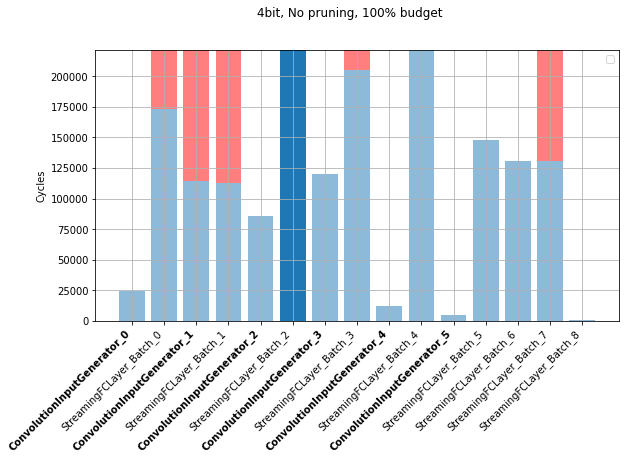

In [477]:
plot_cycles_remainder(new_model, viz_vals, "4bit, No pruning, 100% budget", log=False, start=False)

In [478]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 9 	 27 	 72 	 4 		 1460
	
bitwidth 4
ConvolutionInputGenerator_1 			 4 		 16 	 16 		 812
StreamingFCLayer_Batch_1 		 32 	 8 	 576 	 32 	 128 		 30924
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 4 	 4 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 576 	 24 	 32 		 7252
	
bitwidth 4
ConvolutionInputGenerator_3 			 1 		 4 	 4 		 684
StreamingFCLayer_Batch_3 		 8 	 9 	 1152 	 36 	 32 		 8580
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 2 	 6 	 1152 	 24 	 8 		 2733
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 2304 	 16 	 4 		 2139
	
bitwidth 4
StreamingFCLayer_Batch_6 		 1 	 1 	 256 	 4 	 4 		 2728
	
bitwidth 4
StreamingFCLayer_Batch_7 		 1 	 2 	 512 	 8 	 4 		 2922
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


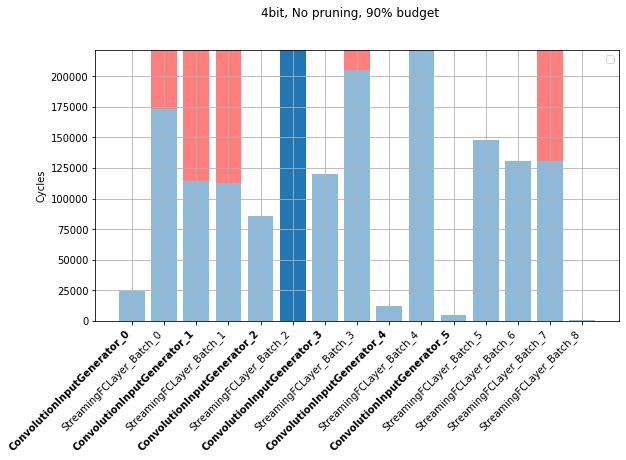

In [436]:
plot_cycles_remainder(new_model, viz_vals, "4bit, No pruning, 90% budget", log=False, start=False)

In [437]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 9 	 27 	 72 	 4 		 1460
	
bitwidth 4
ConvolutionInputGenerator_1 			 4 		 16 	 16 		 812
StreamingFCLayer_Batch_1 		 32 	 8 	 576 	 32 	 128 		 30924
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 4 	 4 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 576 	 24 	 32 		 7252
	
bitwidth 4
ConvolutionInputGenerator_3 			 1 		 4 	 4 		 684
StreamingFCLayer_Batch_3 		 8 	 9 	 1152 	 36 	 32 		 8580
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 2 	 6 	 1152 	 24 	 8 		 2733
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 2304 	 16 	 4 		 2139
	
bitwidth 4
StreamingFCLayer_Batch_6 		 1 	 1 	 256 	 4 	 4 		 2728
	
bitwidth 4
StreamingFCLayer_Batch_7 		 1 	 2 	 512 	 8 	 4 		 2922
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


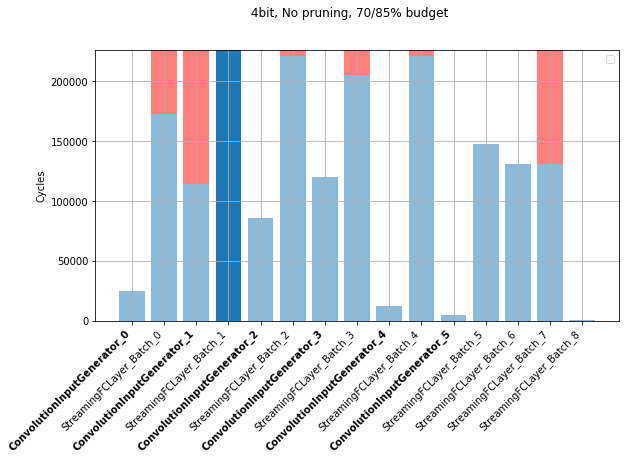

In [426]:
# go with this one
plot_cycles_remainder(new_model, viz_vals, "4bit, No pruning, 70/85% budget", log=False, start=False)

In [427]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 1 	 9 	 27 	 72 	 4 		 1460
	
bitwidth 4
ConvolutionInputGenerator_1 			 4 		 16 	 16 		 812
StreamingFCLayer_Batch_1 		 16 	 8 	 576 	 32 	 64 		 15612
	
bitwidth 4
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 1 		 4 	 4 		 524
StreamingFCLayer_Batch_2 		 8 	 6 	 576 	 24 	 32 		 7252
	
bitwidth 4
ConvolutionInputGenerator_3 			 1 		 4 	 4 		 684
StreamingFCLayer_Batch_3 		 8 	 9 	 1152 	 36 	 32 		 8580
	
bitwidth 4
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 4 	 4 		 460
StreamingFCLayer_Batch_4 		 2 	 6 	 1152 	 24 	 8 		 2733
	
bitwidth 4
ConvolutionInputGenerator_5 			 1 		 4 	 4 		 492
StreamingFCLayer_Batch_5 		 1 	 4 	 2304 	 16 	 4 		 2139
	
bitwidth 4
StreamingFCLayer_Batch_6 		 1 	 1 	 256 	 4 	 4 		 2728
	
bitwidth 4
StreamingFCLayer_Batch_7 		 1 	 2 	 512 	 8 	 4 		 2922
	
bitwidth 4
StreamingFCLayer_Batch_8 		 5 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


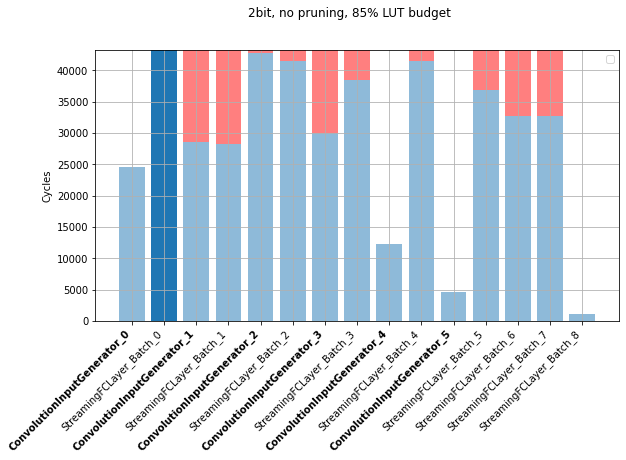

In [551]:
plot_cycles_remainder(new_model, viz_vals, "2bit, no pruning, 85% LUT budget", log=False, start=False)

In [552]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 4 	 9 	 27 	 72 	 8 		 2698
	
bitwidth 2
ConvolutionInputGenerator_1 			 16 		 32 	 32 		 556
StreamingFCLayer_Batch_1 		 64 	 16 	 576 	 32 	 128 		 20434
	
bitwidth 2
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 2 		 4 	 4 		 412
StreamingFCLayer_Batch_2 		 16 	 16 	 576 	 32 	 32 		 5333
	
bitwidth 2
ConvolutionInputGenerator_3 			 4 		 8 	 8 		 492
StreamingFCLayer_Batch_3 		 32 	 12 	 1152 	 24 	 64 		 8924
	
bitwidth 2
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 2 	 2 		 380
StreamingFCLayer_Batch_4 		 4 	 16 	 1152 	 32 	 8 		 1589
	
bitwidth 2
ConvolutionInputGenerator_5 			 1 		 2 	 2 		 396
StreamingFCLayer_Batch_5 		 1 	 16 	 2304 	 32 	 2 		 788
	
bitwidth 2
StreamingFCLayer_Batch_6 		 1 	 4 	 256 	 8 	 2 		 718
	
bitwidth 2
StreamingFCLayer_Batch_7 		 1 	 8 	 512 	 16 	 2 		 801
	
bitwidth 2
StreamingFCLayer_Batch_

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


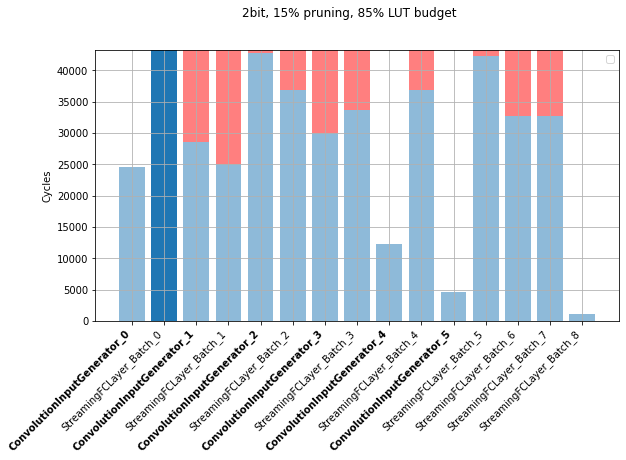

In [333]:
plot_cycles_remainder(new_model, viz_vals, "2bit, 15% pruning, 85% LUT budget", log=False, start=False)

In [334]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 4 	 9 	 27 	 72 	 8 		 2698
	
bitwidth 2
ConvolutionInputGenerator_1 			 16 		 32 	 32 		 556
StreamingFCLayer_Batch_1 		 64 	 16 	 512 	 32 	 128 		 19941
	
bitwidth 2
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 2 		 4 	 4 		 412
StreamingFCLayer_Batch_2 		 16 	 16 	 512 	 32 	 32 		 5210
	
bitwidth 2
ConvolutionInputGenerator_3 			 4 		 8 	 8 		 492
StreamingFCLayer_Batch_3 		 32 	 12 	 1008 	 24 	 64 		 8677
	
bitwidth 2
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 2 	 2 		 380
StreamingFCLayer_Batch_4 		 8 	 8 	 1024 	 16 	 16 		 1972
	
bitwidth 2
ConvolutionInputGenerator_5 			 1 		 2 	 2 		 396
StreamingFCLayer_Batch_5 		 2 	 6 	 1980 	 12 	 4 		 779
	
bitwidth 2
StreamingFCLayer_Batch_6 		 2 	 2 	 256 	 4 	 4 		 766
	
bitwidth 2
StreamingFCLayer_Batch_7 		 4 	 2 	 512 	 4 	 8 		 960
	
bitwidth 2
StreamingFCLayer_Batch_8 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


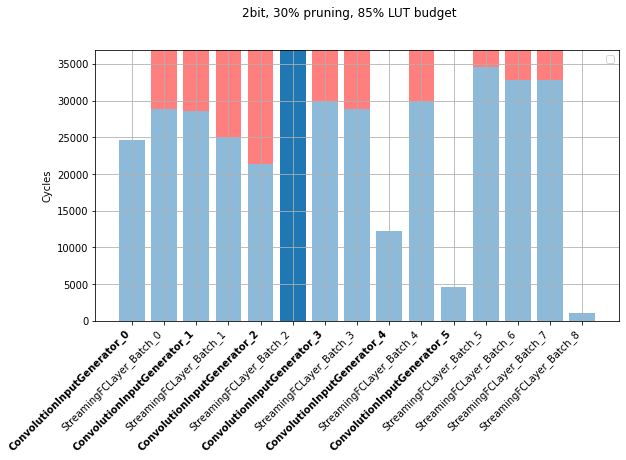

In [345]:
plot_cycles_remainder(new_model, viz_vals, "2bit, 30% pruning, 85% LUT budget", log=False, start=False)

In [347]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 4 	 9 	 18 	 72 	 8 		 2698
	
bitwidth 2
ConvolutionInputGenerator_1 			 16 		 32 	 32 		 556
StreamingFCLayer_Batch_1 		 64 	 16 	 512 	 32 	 128 		 19941
	
bitwidth 2
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 4 		 8 	 8 		 428
StreamingFCLayer_Batch_2 		 16 	 16 	 512 	 32 	 32 		 5210
	
bitwidth 2
ConvolutionInputGenerator_3 			 4 		 8 	 8 		 492
StreamingFCLayer_Batch_3 		 32 	 12 	 864 	 24 	 64 		 8677
	
bitwidth 2
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 2 	 2 		 380
StreamingFCLayer_Batch_4 		 8 	 8 	 832 	 16 	 16 		 1972
	
bitwidth 2
ConvolutionInputGenerator_5 			 1 		 2 	 2 		 396
StreamingFCLayer_Batch_5 		 2 	 6 	 1620 	 12 	 4 		 779
	
bitwidth 2
StreamingFCLayer_Batch_6 		 2 	 2 	 256 	 4 	 4 		 766
	
bitwidth 2
StreamingFCLayer_Batch_7 		 4 	 2 	 512 	 4 	 8 		 960
	
bitwidth 2
StreamingFCLayer_Batch_8 		

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


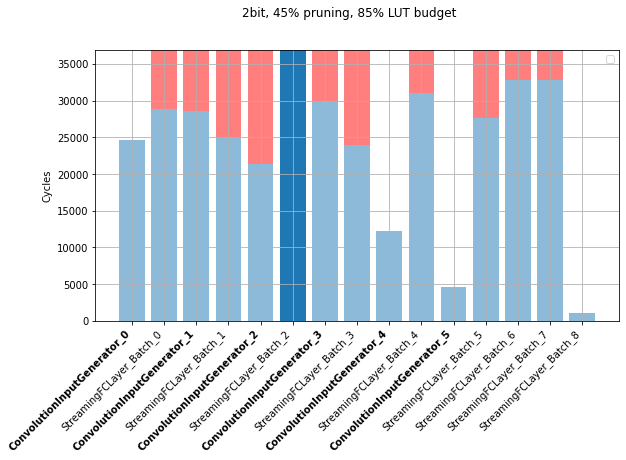

In [403]:
plot_cycles_remainder(new_model, viz_vals, "2bit, 45% pruning, 85% LUT budget", log=False, start=False)

In [404]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 4 	 9 	 18 	 72 	 8 		 2698
	
bitwidth 2
ConvolutionInputGenerator_1 			 16 		 32 	 32 		 556
StreamingFCLayer_Batch_1 		 64 	 16 	 512 	 32 	 128 		 19941
	
bitwidth 2
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 4 		 8 	 8 		 428
StreamingFCLayer_Batch_2 		 16 	 16 	 512 	 32 	 32 		 5210
	
bitwidth 2
ConvolutionInputGenerator_3 			 4 		 8 	 8 		 492
StreamingFCLayer_Batch_3 		 32 	 12 	 720 	 24 	 64 		 8677
	
bitwidth 2
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 2 	 2 		 380
StreamingFCLayer_Batch_4 		 8 	 6 	 648 	 12 	 16 		 1760
	
bitwidth 2
ConvolutionInputGenerator_5 			 1 		 2 	 2 		 396
StreamingFCLayer_Batch_5 		 2 	 6 	 1296 	 12 	 4 		 779
	
bitwidth 2
StreamingFCLayer_Batch_6 		 2 	 2 	 256 	 4 	 4 		 766
	
bitwidth 2
StreamingFCLayer_Batch_7 		 4 	 2 	 512 	 4 	 8 		 960
	
bitwidth 2
StreamingFCLayer_Batch_8 		

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


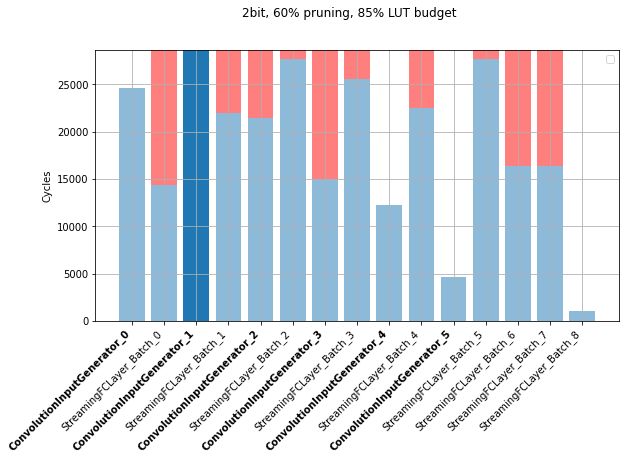

In [466]:
plot_cycles_remainder(new_model, viz_vals, "2bit, 60% pruning, 85% LUT budget", log=False, start=False)

In [447]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 4 	 9 	 9 	 72 	 8 		 2667
	
bitwidth 2
ConvolutionInputGenerator_1 			 16 		 32 	 32 		 556
StreamingFCLayer_Batch_1 		 32 	 16 	 224 	 32 	 64 		 9874
	
bitwidth 2
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 4 		 8 	 8 		 428
StreamingFCLayer_Batch_2 		 16 	 12 	 288 	 24 	 32 		 4365
	
bitwidth 2
ConvolutionInputGenerator_3 			 8 		 16 	 16 		 492
StreamingFCLayer_Batch_3 		 16 	 16 	 512 	 32 	 32 		 5210
	
bitwidth 2
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 2 	 2 		 380
StreamingFCLayer_Batch_4 		 8 	 6 	 468 	 12 	 16 		 1699
	
bitwidth 2
ConvolutionInputGenerator_5 			 1 		 2 	 2 		 396
StreamingFCLayer_Batch_5 		 1 	 9 	 972 	 18 	 2 		 660
	
bitwidth 2
StreamingFCLayer_Batch_6 		 4 	 2 	 256 	 4 	 8 		 916
	
bitwidth 2
StreamingFCLayer_Batch_7 		 4 	 4 	 512 	 8 	 8 		 1065
	
bitwidth 2
StreamingFCLayer_Batch_8 		 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


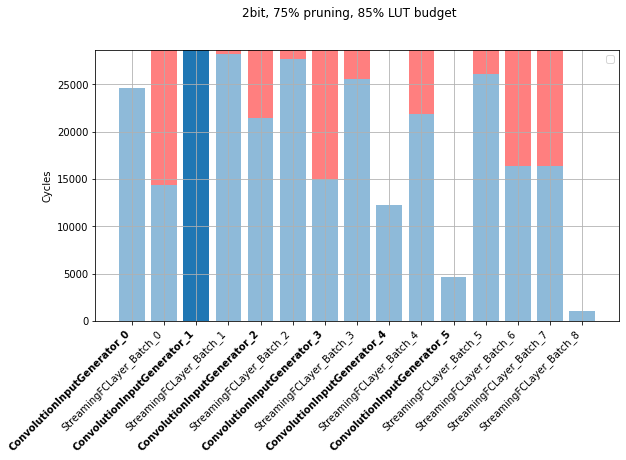

In [456]:
plot_cycles_remainder(new_model, viz_vals, "2bit, 75% pruning, 85% LUT budget", log=False, start=False)

In [457]:
get_res(new_model, old_estimation=False)

layer 					 PE 	 SIMD 	 MW 	 inWidth outWidth 	 LUTs
ConvolutionInputGenerator_0 			 1 		 8 	 8 		 364
StreamingFCLayer_Batch_0 		 8 	 3 	 6 	 24 	 16 		 2332
	
bitwidth 2
ConvolutionInputGenerator_1 			 16 		 32 	 32 		 556
StreamingFCLayer_Batch_1 		 16 	 16 	 144 	 32 	 32 		 5087
	
bitwidth 2
StreamingMaxPool_Batch_0
ConvolutionInputGenerator_2 			 4 		 8 	 8 		 428
StreamingFCLayer_Batch_2 		 8 	 12 	 144 	 24 	 16 		 2271
	
bitwidth 2
ConvolutionInputGenerator_3 			 8 		 16 	 16 		 492
StreamingFCLayer_Batch_3 		 16 	 16 	 512 	 32 	 32 		 5210
	
bitwidth 2
StreamingMaxPool_Batch_1
ConvolutionInputGenerator_4 			 1 		 2 	 2 		 380
StreamingFCLayer_Batch_4 		 8 	 4 	 304 	 8 	 16 		 1488
	
bitwidth 2
ConvolutionInputGenerator_5 			 1 		 2 	 2 		 396
StreamingFCLayer_Batch_5 		 1 	 6 	 612 	 12 	 2 		 621
	
bitwidth 2
StreamingFCLayer_Batch_6 		 4 	 2 	 256 	 4 	 8 		 916
	
bitwidth 2
StreamingFCLayer_Batch_7 		 4 	 4 	 512 	 8 	 8 		 1065
	
bitwidth 2
StreamingFCLayer_Batch_8 		 5

In [394]:
def plot_cycles_remainder(model, old_vals, title, prev_cycles = None, log = True, start = True):
    graph = model.graph
    vals = dict()
    
    for node in graph.node:
        if node.op_type in ("StreamingFCLayer_Batch", "ConvolutionInputGenerator", "ConvolutionInputGeneratorPruned"):
            node_inst = getCustomOp(node)
            vals[node.name] = node_inst.get_exp_cycles()

    fig, ax = plt.subplots(figsize=(8,5))
    fig.patch.set_facecolor('white')
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])

    ax.set_xticklabels(list(vals.keys()), rotation = 45, ha='right')

    if log:
        ax.set_yscale('log')

    #plt.rcParams['figure.facecolor'] = 'grey'
    fig.suptitle(title, wrap=True, fontsize=12)
    plt.ylabel('Cycles')

    # opacity
    highest_layer, highest_val = sorted(vals.items(), key=lambda item: item[1], reverse=True)[0]
    alphas = ([.5 if x != highest_layer else 1 for x in list(vals.keys())])
    rgba_colors = np.zeros((15,4))
    rgba_colors[:,0] = 31 / 255
    rgba_colors[:,1] = 119 / 255
    rgba_colors[:,2] = 180 / 255
    rgba_colors[:, 3] = alphas
    
    excess_vals = dict()
    for idx, v in enumerate(vals.items()):
        old_val = list(old_vals.values())[idx]
        if v[1] < old_val:
            excess_vals[v[0]] = highest_val - v[1]
        else:
            excess_vals[v[0]] = 0
    
    
    ax.bar(list(vals.keys()), list(vals.values()), color = rgba_colors)
    ax.bar(list(excess_vals.keys()), list(excess_vals.values()), bottom=list(vals.values()), color = 'red', alpha = 0.5)

    #if prev_cycles:
        #prev_excess = [i+j for i,j in zip(vals.values(), excess_vals.values())]
        
        #prev_diff = [j-i for i,j in zip(vals.values(), prev_cycles.values())]
        
        #ax.bar(list(prev_cycles.keys()), prev_diff, bottom=prev_excess, color = 'green', alpha = 0.5)
    
    if start:
        ax.scatter(list(old_vals.keys()), list(old_vals.values()), marker = "x", color = 'orange', label = 'Start')
    
    for x,y in zip(ax.get_xticklabels(), list(vals.keys())):
        if y[:25] == "ConvolutionInputGenerator":
            x.set_weight("bold")
    ax.grid()
    plt.legend()
    plt.show()

In [623]:
def _is_dwc_node(node):
    if node.op_type == "StreamingDataWidthConverter_Batch":
        return True
    else:
        return False


def _suitable_node(node):
    if node is not None:
        if is_fpgadataflow_node(node) is True:
            if _is_dwc_node(node):
                # no DWC for DWCs
                return False
            elif node.op_type == "IODMA":
                # IODMA data shapes/widths need special handling
                return False
            else:
                return True
        else:
            return False
    else:
        return False

In [624]:
def check_widths(model):
    graph = model.graph
    node_ind = -1
    graph_modified = False
    for n in graph.node:
        node_ind += 1
        if _suitable_node(n):
            for n_output in n.output:
                consumers = model.find_consumers(n_output)
                if consumers is None:
                    continue
                if len(consumers) > 1:
                    warnings.warn(
                        n.name
                        + ": HLS node with fan-out higher than 1 cannot be stitched"
                    )

                consumer = consumers[0]
                if _suitable_node(consumer) is True:
                    n0 = getCustomOp(n)
                    n1 = getCustomOp(consumer)
                    print("parent", n.name, "\t child", consumer.name)
                    dwc_in = n0.get_outstream_width()
                    dwc_out = n1.get_instream_width()
                    print(f"\t DWC in: {dwc_in}, DWC out: {dwc_out}")
                    if dwc_in > dwc_out:
                        print(dwc_in % dwc_out)
                    else:
                        print(dwc_out % dwc_in)
        print('\n')